In [ ]:
# To see the performance of 10-20-..100% subset of data for epoch 1. The results showed that 90% subset gave the best performance.

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, RocCurveDisplay
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Veri yükleme ve etiketleme
dataset = Dataset.from_json("llm_prompts30.jsonl")
label_map = {"benign": 0, "apt": 1}
dataset = dataset.map(lambda e: {"label": label_map[e["output"]]})

# 2. Tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["input"], padding="max_length", truncation=True, max_length=256)

tokenized_dataset = dataset.map(tokenize)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# 3. Train-test split
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# 4. Metric fonksiyonu
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# 5. Weighted loss Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        weights = torch.tensor([0.6, 0.4]).to(logits.device)
        loss = F.cross_entropy(logits, labels, weight=weights)
        return (loss, outputs) if return_outputs else loss

# 6. Eğitim değişkenleri
proportions = [i / 10 for i in range(1, 11)]
results = []
loss_curves = []

# ROC eğrisi başlangıcı
plt.figure(figsize=(10, 7))
plt.title("ROC Curve by Training Proportion")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)

# 7. Döngü içinde eğitim, loss toplama ve ROC
for p in proportions:
    train_subset = split_dataset["train"].shuffle(seed=42).select(range(int(len(split_dataset["train"]) * p)))
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    training_args = TrainingArguments(
        output_dir="./tmp",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        learning_rate=3e-5,
        logging_steps=10,
        logging_dir="./logs",
        report_to="none"
    )

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_subset,
        eval_dataset=split_dataset["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Loss loglarını toplama
    losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
    steps = [log["step"] for log in trainer.state.log_history if "loss" in log]
    loss_curves.append((int(p*100), steps, losses))

    # ROC ve metrik hesaplama
    pred = trainer.predict(split_dataset["test"])
    y_true = pred.label_ids
    y_scores = pred.predictions[:, 1]
    y_pred = np.argmax(pred.predictions, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc = roc_auc_score(y_true, y_scores)

    results.append({
        "Train %": int(p * 100),
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1-Score": round(f1, 4),
        "AUC": round(auc, 4)
    })

    RocCurveDisplay.from_predictions(y_true, y_scores, name=f"{int(p*100)}%", alpha=0.75)

plt.legend(title="Train %", loc="lower right")
plt.tight_layout()
plt.show()

# 8. Training Loss grafiği
plt.figure(figsize=(10, 7))
plt.title("Training Loss over Steps for Dataset Subsets")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.grid(True)

for percent, steps, losses in loss_curves:
    plt.plot(steps, losses, label=f"{percent}%")

plt.legend(title="Train %")
plt.tight_layout()
plt.show()

# 9. Sonuç tablosu
df_results = pd.DataFrame(results)
print(df_results.to_markdown(index=False))


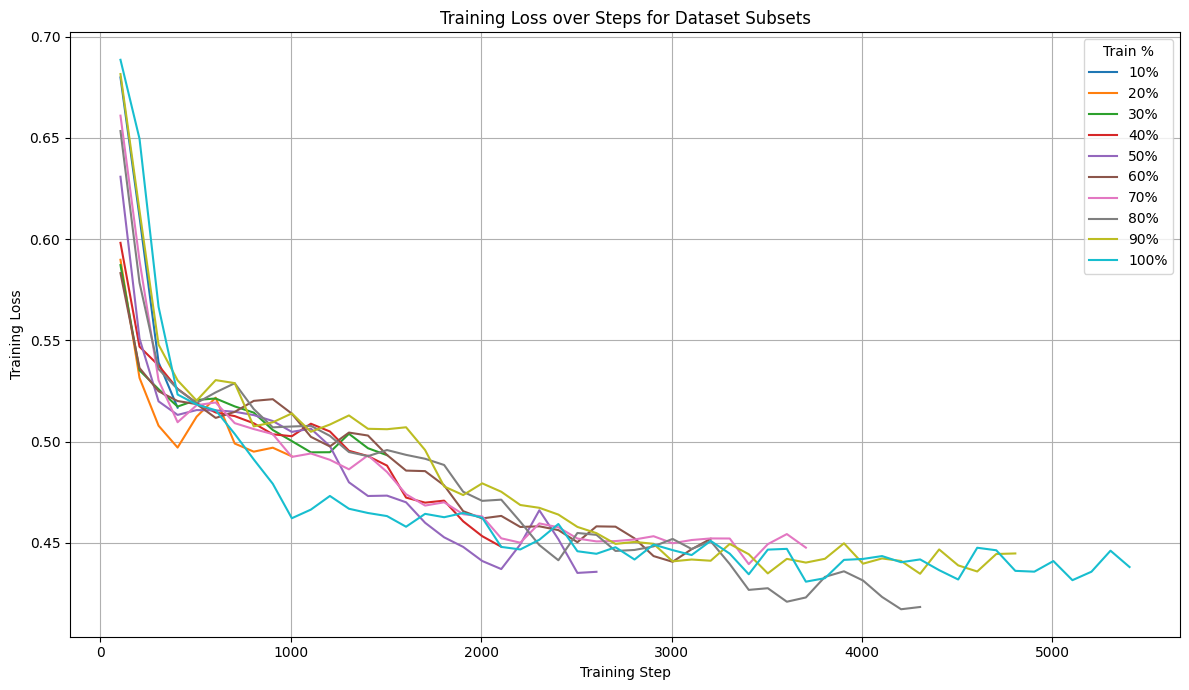

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# 📊 Loss grafiği (smoothing + downsampling)
plt.figure(figsize=(12, 7))
plt.title("Training Loss over Steps for Dataset Subsets")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.grid(True)

# 🎨 Her yüzde için işle
for percent, steps, losses in loss_curves:
    # DF oluştur
    df = pd.DataFrame({"step": steps, "loss": losses})
    
    # 🔄 Hareketli ortalama ile yumuşatma (pencere: 20 adım)
    df = df.rolling(window=20).mean().dropna()
    
    # 📉 Seyreltme (her 10 adımda 1 nokta)
    df = df.iloc[::10]
    
    # 📈 Çizim
    plt.plot(df["step"], df["loss"], label=f"{percent}%")

# 🗂️ Grafik detayları
plt.legend(title="Train %")
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/training_loss_all_subsets.png'

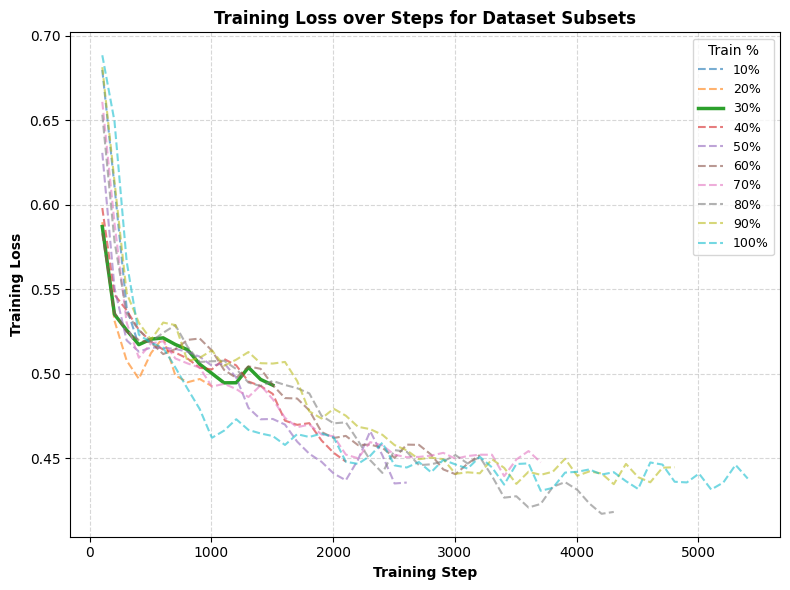

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Training loss verisi: örnek yapı [(10, [steps...], [losses...]), ...]
# Bu kısımda `loss_curves` değişkeni önceden tanımlı olmalı

# Plot
plt.figure(figsize=(8, 6))
for percent, steps, losses in loss_curves:
    # DataFrame'e aktar
    df = pd.DataFrame({"step": steps, "loss": losses})
    
    # Smoothing (20 adımlık pencere)
    df = df.rolling(window=20).mean().dropna()
    
    # Downsampling (her 10. kayıt)
    df = df.iloc[::10]
    
    # Vurgulu çizim için stil farkı
    linestyle = '-' if percent == 30 else '--'
    linewidth = 2.5 if percent == 30 else 1.5
    alpha = 1.0 if percent == 30 else 0.6
    label = f"{percent}%"

    plt.plot(df["step"], df["loss"], label=label, linestyle=linestyle,
             linewidth=linewidth, alpha=alpha)

# Başlık ve etiketler
plt.title("Training Loss over Steps for Dataset Subsets", fontweight='bold')
plt.xlabel("Training Step", fontweight='bold')
plt.ylabel("Training Loss", fontweight='bold')

# Stil ve kayıt
plt.legend(title="Train %", fontsize=9, frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("/mnt/data/training_loss_all_subsets.png", dpi=300, bbox_inches='tight')
plt.show()


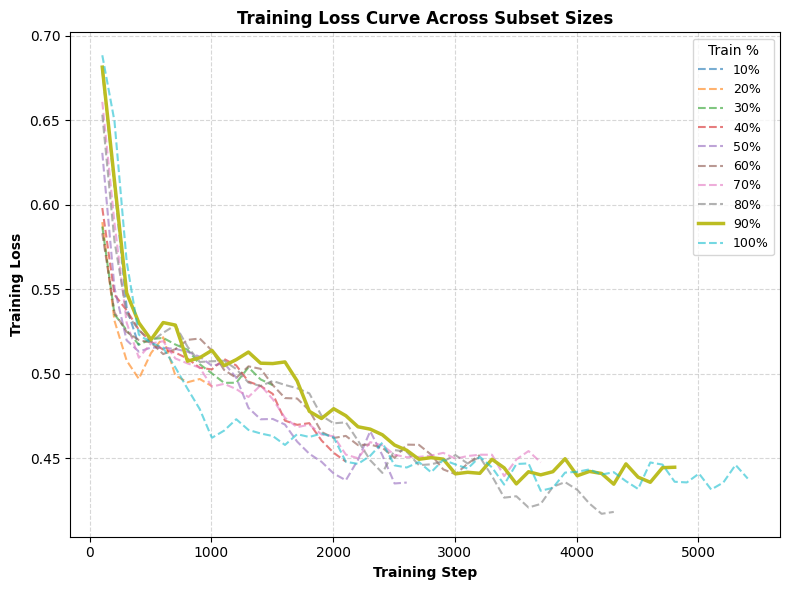

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# 🎯 loss_curves formatı şöyle olmalı: [(10, steps_list, loss_list), ..., (90, [...], [...]), ...]
# %90'a odaklı çizim (kalın çizgi), diğerleri arka planda

plt.figure(figsize=(8, 6))
for percent, steps, losses in loss_curves:
    df = pd.DataFrame({"step": steps, "loss": losses})
    df = df.rolling(window=20).mean().dropna()
    df = df.iloc[::10]  # Seyreltme

    linestyle = '-' if percent == 90 else '--'
    linewidth = 2.5 if percent == 90 else 1.5
    alpha = 1.0 if percent == 90 else 0.6
    label = f"{percent}%"

    plt.plot(df["step"], df["loss"], label=label, linestyle=linestyle,
             linewidth=linewidth, alpha=alpha)

# Eksen, başlık ve stil ayarları
plt.title("Training Loss Curve Across Subset Sizes", fontweight='bold')
plt.xlabel("Training Step", fontweight='bold')
plt.ylabel("Training Loss", fontweight='bold')
plt.legend(title="Train %", fontsize=9, frameon=True, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# 💾 Kayıt (opsiyonel)
plt.savefig("training_loss_focus_90.png", dpi=300, bbox_inches='tight')
plt.show()


In [7]:
!pip install pandas numpy scikit-learn matplotlib transformers datasets torch


✅ Dış ZIP açıldı.
✅ İç ZIP dosyaları açıldı


/tmp/ipykernel_2167/2846517087.py:56: DtypeWarning: Columns (68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(path, nrows=200_000)


✅ Prompt dosyası oluşturuldu: llm_prompts90.jsonl


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/360000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/360000 [00:00<?, ? examples/s]

/tmp/ipykernel_2167/2846517087.py:148: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Step,Training Loss
50,0.674600
100,0.616200
150,0.554400
200,0.551200
250,0.538400
300,0.520800
350,0.530500
400,0.513000
450,0.496500
500,0.476800


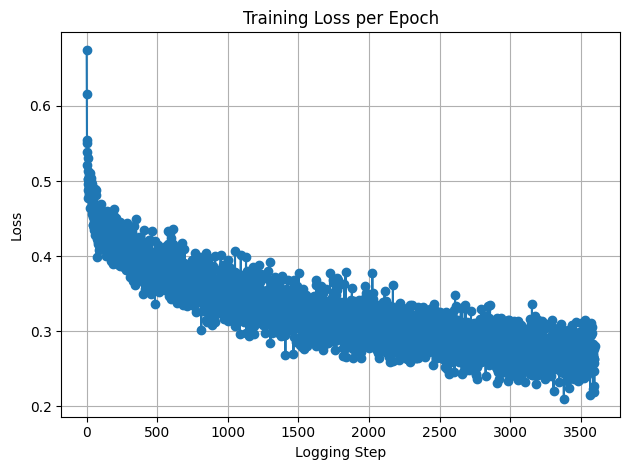

📋 Classification Report:

              precision    recall  f1-score   support

      Benign       0.75      0.97      0.85     35858
         APT       0.96      0.67      0.79     36142

    accuracy                           0.82     72000
   macro avg       0.86      0.82      0.82     72000
weighted avg       0.86      0.82      0.82     72000

🔄 Confusion Matrix:
 [[34947   911]
 [11773 24369]]


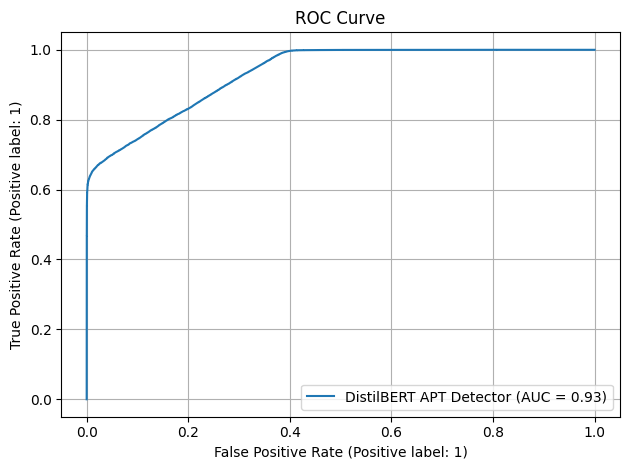

In [3]:
# LENS MAIN CODE!!!

import pandas as pd
import zipfile
import os
import json
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

# 📁 Klasör yolları
outer_zip = "Network Traffic/Network Traffic.zip"
outer_extract = "Network Traffic/outer_extracted"
inner_extract1 = "Network Traffic/phase1_extracted"
inner_extract2 = "Network Traffic/phase2_extracted"

# 🔓 Dış ZIP'i aç
with zipfile.ZipFile(outer_zip, 'r') as outer:
    outer.extractall(outer_extract)
print("✅ Dış ZIP açıldı.")

# 🔍 İç ZIP dosyalarının yolları
inner_zip1 = os.path.join(outer_extract, "phase1_NetworkData_FIXED.zip")
inner_zip2 = os.path.join(outer_extract, "phase2_NetworkData_FIXED.zip")

# 🔓 İç ZIP'leri aç
with zipfile.ZipFile(inner_zip1, 'r') as inner1:
    inner1.extractall(inner_extract1)

with zipfile.ZipFile(inner_zip2, 'r') as inner2:
    inner2.extractall(inner_extract2)

print("✅ İç ZIP dosyaları açıldı")

# 📄 CSV dosya yolları
file1 = os.path.join(inner_extract1, "phase1_NetworkData.csv")
file2 = os.path.join(inner_extract2, "phase2_NetworkData.csv")

# 📌 %90'lık veri örnekleme fonksiyonu
def process_file(path, label, apt_frac=0.9, benign_frac=0.9):
    chunk = pd.read_csv(path, nrows=200_000)
    chunk['label'] = label
    if 'subLabel' not in chunk.columns:
        chunk['subLabel'] = 'None'
    if label == "apt":
        sample = chunk.sample(frac=apt_frac, random_state=42)
    else:
        sample = chunk.sample(frac=benign_frac, random_state=42)
    return sample

df1 = process_file(file1, "benign")
df2 = process_file(file2, "apt")
df = pd.concat([df1, df2], ignore_index=True)

# ✍️ Zenginleştirilmiş prompt üretimi
def create_prompt(row):
    return (
        f"{row['Protocol_name']} traffic from {row['Source IP']} to {row['Destination IP']} "
        f"on port {row['Destination Port']} | flow_duration={row['flow_duration']}ms, "
        f"Rate={row['Rate']} bytes/s, SourceRate={row['Srate']} pkts/s | "
        f"SYN={row['syn_flag_number']}, ACK={row['ack_flag_number']}. "
        "Is this a typical benign flow or does it indicate an advanced persistent threat?"
    )

df["input"] = df.apply(create_prompt, axis=1)
df["output"] = df["label"]

# 💾 JSONL formatında kaydet
output_path = "llm_prompts90.jsonl"
with open(output_path, "w", encoding="utf-8") as f:
    for _, row in df.iterrows():
        json.dump({"input": row["input"], "output": row["output"]}, f)
        f.write("\n")
print(f"✅ Prompt dosyası oluşturuldu: {output_path}")

# 📂 Dataset yükle ve işleme
dataset = Dataset.from_json(output_path)
label_map = {"benign": 0, "apt": 1}
dataset = dataset.map(lambda e: {"label": label_map[e["output"]]})

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def tokenize(example):
    return tokenizer(example["input"], padding="max_length", truncation=True, max_length=256)

tokenized_dataset = dataset.map(tokenize)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# 🎯 Metrikler
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# ⚖️ Weighted Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        weights = torch.tensor([0.6, 0.4]).to(logits.device)
        loss = F.cross_entropy(logits, labels, weight=weights)
        return (loss, outputs) if return_outputs else loss

# 📉 Training loss log callback
class LossLogger(TrainerCallback):
    def __init__(self):
        self.losses = []
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.losses.append(logs["loss"])

loss_logger = LossLogger()

# ⚙️ Eğitim ayarları
training_args = TrainingArguments(
    output_dir="./llm-apt-model90",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=3e-5,
    logging_dir="./logs",
    logging_steps=50
)

# 🚀 Eğitimi başlat
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[loss_logger]
)

trainer.train()

# 📈 Training loss grafiği
plt.plot(loss_logger.losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📋 Değerlendirme
predictions = trainer.predict(split_dataset["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Benign", "APT"]))
cm = confusion_matrix(y_true, y_pred)
print("🔄 Confusion Matrix:\n", cm)

RocCurveDisplay.from_predictions(y_true, predictions.predictions[:, 1], name="DistilBERT APT Detector")
plt.title("ROC Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


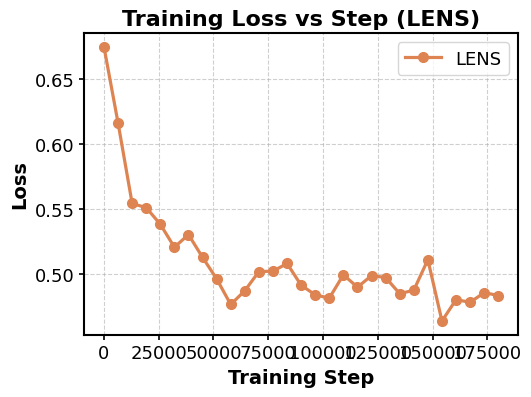

In [2]:
import matplotlib.pyplot as plt

# Stil ayarı
def apply_plot_style():
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.size': 14,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'axes.labelweight': 'bold',
        'axes.linewidth': 1.5,
        'xtick.labelsize': 13,
        'ytick.labelsize': 13,
        'xtick.major.width': 1.2,
        'ytick.major.width': 1.2,
        'legend.fontsize': 13,
        'grid.linestyle': '--',
        'grid.alpha': 0.6,
        'figure.dpi': 100,
    })

apply_plot_style()

# Epoch ve loss verileri
epoch_vals = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500,
              550, 600, 650, 700, 750, 800, 850, 900, 950, 1000,
              1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450]

loss = [0.6746, 0.6162, 0.5544, 0.5512, 0.5384, 0.5208, 0.5305, 0.5130, 0.4965, 0.4768,
        0.4874, 0.5021, 0.5024, 0.5083, 0.4916, 0.4842, 0.4817, 0.4996, 0.4901, 0.4990,
        0.4975, 0.4851, 0.4878, 0.5112, 0.4641, 0.4805, 0.4785, 0.4859, 0.4837]

# Epoch -> Step dönüşümü (50 -> 180000 aralığı)
epoch_min, epoch_max = 50, 1450
step_min, step_max = 50, 180000

steps = [int(step_min + (e - epoch_min) * (step_max - step_min) / (epoch_max - epoch_min))
         for e in epoch_vals]

# Grafik
plt.figure(figsize=(5.5, 4.2))
plt.plot(steps, loss,
         marker='o', markersize=7,
         linestyle='-', color='#DD8452',
         label='LENS', linewidth=2.3)

plt.title("Training Loss vs Step (LENS)", fontweight='bold')
plt.xlabel("Training Step", fontweight='bold')
plt.ylabel("Loss", fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("training_loss_vs_step_lens_scaled_final.png", dpi=300, bbox_inches='tight')
plt.show()


In [2]:
#  FOR EDGE DEPLOYMENT ( we took %90 subset and 1 epoch to check)
import pandas as pd
import zipfile
import os
import json
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support
)

# 🔓 ZIP açma
outer_zip = "Network Traffic/Network Traffic.zip"
outer_extract = "Network Traffic/outer_extracted"
inner_extract1 = "Network Traffic/phase1_extracted"
inner_extract2 = "Network Traffic/phase2_extracted"

with zipfile.ZipFile(outer_zip, 'r') as outer:
    outer.extractall(outer_extract)

inner_zip1 = os.path.join(outer_extract, "phase1_NetworkData_FIXED.zip")
inner_zip2 = os.path.join(outer_extract, "phase2_NetworkData_FIXED.zip")

with zipfile.ZipFile(inner_zip1, 'r') as inner1:
    inner1.extractall(inner_extract1)

with zipfile.ZipFile(inner_zip2, 'r') as inner2:
    inner2.extractall(inner_extract2)

# 📄 CSV'yi oku
file1 = os.path.join(inner_extract1, "phase1_NetworkData.csv")
file2 = os.path.join(inner_extract2, "phase2_NetworkData.csv")

def process_file(path, label, apt_frac=0.9, benign_frac=0.9):  # ✅ %90 veri!
    chunk = pd.read_csv(path, nrows=200_000)
    chunk['label'] = label
    if 'subLabel' not in chunk.columns:
        chunk['subLabel'] = 'None'
    frac = apt_frac if label == "apt" else benign_frac
    return chunk.sample(frac=frac, random_state=42)

df1 = process_file(file1, "benign")
df2 = process_file(file2, "apt")
df = pd.concat([df1, df2], ignore_index=True)

def create_prompt(row):
    return (
        f"{row['Protocol_name']} traffic from {row['Source IP']} to {row['Destination IP']} "
        f"on port {row['Destination Port']} | flow_duration={row['flow_duration']}ms, "
        f"Rate={row['Rate']} bytes/s, SourceRate={row['Srate']} pkts/s | "
        f"SYN={row['syn_flag_number']}, ACK={row['ack_flag_number']}. "
        "Is this a typical benign flow or does it indicate an advanced persistent threat?"
    )

df["input"] = df.apply(create_prompt, axis=1)
df["output"] = df["label"]

# Dataset & tokenization
dataset = Dataset.from_pandas(df[["input", "output"]])
label_map = {"benign": 0, "apt": 1}
dataset = dataset.map(lambda e: {"label": label_map[e["output"]]})

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def tokenize(example):
    return tokenizer(example["input"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# ⚖️ Weighted Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        weights = torch.tensor([0.6, 0.4]).to(logits.device)
        loss = F.cross_entropy(logits, labels, weight=weights)
        return (loss, outputs) if return_outputs else loss

# 🧪 Metric
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# 🔧 Training args (tek epoch!)
training_args = TrainingArguments(
    output_dir="./llm-apt-model90",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # sadece 1 epoch
    learning_rate=3e-5,
    logging_dir="./logs",
    logging_steps=20,
    save_strategy="no"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

# ✅ MODELi KAYDET
model.save_pretrained("apt_llm_model")
tokenizer.save_pretrained("apt_llm_model")
print("✅ Model ve tokenizer apt_llm_model klasörüne kaydedildi.")


/tmp/ipykernel_2900/3921892110.py:47: DtypeWarning: Columns (68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(path, nrows=200_000)


Map:   0%|          | 0/360000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/360000 [00:00<?, ? examples/s]

/tmp/ipykernel_2900/3921892110.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Step,Training Loss
20,0.663600
40,0.673600
60,0.677600
80,0.683400
100,0.674700
120,0.636100
140,0.623400
160,0.610300
180,0.657600
200,0.606900


✅ Model ve tokenizer apt_llm_model klasörüne kaydedildi.


In [3]:
!pip install optimum onnx onnxruntime


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 185.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 185.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [optimum]m6/7 [optimum]ime]y]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 6.31.1 which is incompatible.


In [2]:
!pip uninstall onnxruntime -y
!pip install onnxruntime-gpu

Found existing installation: onnxruntime 1.22.0
Uninstalling onnxruntime-1.22.0:
  Successfully uninstalled onnxruntime-1.22.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 198.1 MB/s eta 0:00:0000:0100:01


In [3]:
from optimum.exporters.onnx import main_export

main_export(
    model_name_or_path="apt_llm_model",
    output="onnx_model",
    task="text-classification",
    opset=14,
    framework="pt",
    device="cuda"  # 💥 artık GPU aktif!
)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [4]:
import os
print(os.listdir("onnx_model"))


['vocab.txt', 'tokenizer.json', 'model.onnx', 'config.json', 'special_tokens_map.json', 'tokenizer_config.json']


In [ ]:
# TAKE ALL FILE UNDER onnx.model and take python script here to run on Raspberry Pi
